https://lloydrochester.com/post/c/convolution/

In [34]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import copy

plt.style.use('ggplot')

## get sample noisy data set

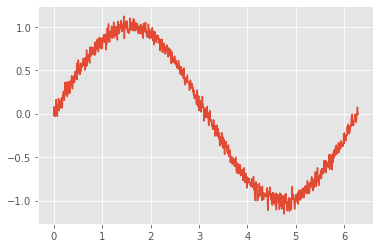

In [18]:
x = np.linspace(0, 2*np.pi, 1000)
y = np.sin(x) + np.random.normal(0,0.05,1000)
plt.plot(x, y)

## numpy convolution

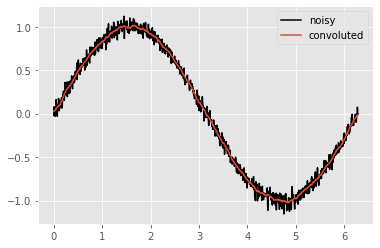

In [19]:
smoothing_size = 20 # convolution smoothing size
np_conv = np.convolve(y, np.ones(smoothing_size), 'same') / smoothing_size

plt.plot(x, y, label='noisy', color='black')
plt.plot(x, np_conv, label='convoluted')
plt.legend()

## C like convolution

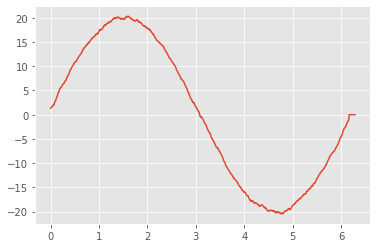

In [20]:
c_conv = np.zeros(1000)
smoothing_window = np.ones(smoothing_size)
for i in range(len(y) - smoothing_size):
    for ii in range(smoothing_size):
        c_conv[i] = c_conv[i] + y[ii + i] * smoothing_window[smoothing_size - 1 - ii]
        
plt.plot(x, c_conv)

## sample signal for derivative impl testing

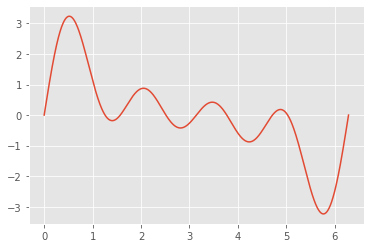

In [21]:
grad_test_sig = np.sum([np.sin(x*i) for i in range(5)], axis=0)
plt.plot(x, grad_test_sig)

## numpy gradient

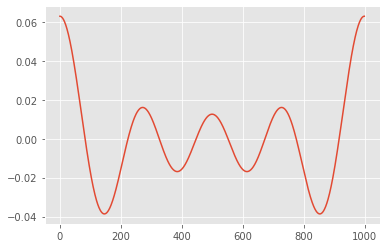

In [22]:
np_grad = np.gradient(grad_test_sig)
plt.plot(np_grad)

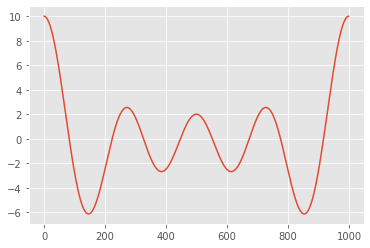

In [23]:
plt.plot(np.diff(grad_test_sig) / np.diff(x))

## C like derivative

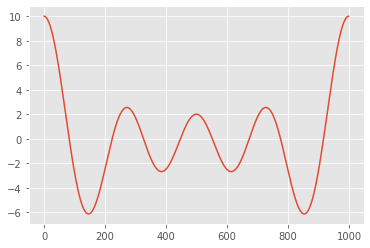

In [24]:
c_der = np.zeros(len(x) - 1)
for i in range(len(x) - 1):
    c_der[i] = (grad_test_sig[i+1] - grad_test_sig[i]) / (x[i+1] - x[i])
plt.plot(c_der)

## python peak finder

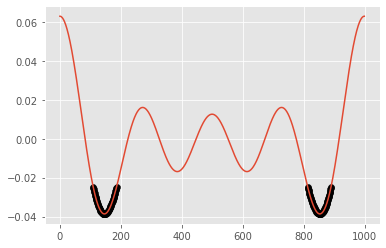

In [25]:
peak_locs = np.where(np_grad<-np.std(np_grad))
plt.scatter(peak_locs,np_grad[peak_locs] , color='k')
plt.plot(np_grad)

In [26]:
np.std(np_grad)

0.024425971459257623

## Welford's algorithm

In [29]:
def welfords_algorithm(signal):
    SIZE = len(signal)
    mean = 0
    M2 = 0
    variance = 0

    for i in range(SIZE):
        s = signal[i]
        delta = s - mean
        mean += delta / (i + 1)
        M2 += delta * (s - mean)
    
    variance = M2 / SIZE
    return np.sqrt(variance)

In [30]:
welfords_algorithm(np_grad)

0.02442597145925763

In [46]:
def mean_c(array):
    sum = 0
    for i in range(len(array)):
        sum = sum + array[i]
    return sum / len(array)

def diff_c(array):
    a = np.zeros(len(array))
    for i in range(len(a) - 1):
        a[i] = array[i+1] - array[i] 
    return a[:-1]

def heart_rate_c(signal, time):
    assert len(signal) == len(time)
    true_peak_times, pk_time_span = [],[]
    
    std_dev = welfords_algorithm(signal)
    for i in range(len(signal)):
        if signal[i] < -std_dev:
            pk_time_span.append(time[i])
        elif len(pk_time_span) != 0:
            true_peak_times.append(mean_c(pk_time_span))
            pk_time_span.clear()

    print('BPM: {0:2.1f}'.format(60.0 / mean_c(diff_c(true_peak_times))))  